In [87]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis

import pynumtools.kmc as kmc

#mpl.rcParams['figure.figsize'] = (13, 13)
import matplotlib.pyplot as plt

In [2]:
def plot_overview(plot_functions, n_rows=2, n_cols=2, size_factor=1.):
    plt.figure(1, figsize=(5*n_cols*size_factor,3.5*n_rows*size_factor))
    n_plots = n_rows * n_cols
    idx = 1
    for pf in plot_functions:
        if idx > n_plots:
            break
        plt.subplot(n_rows, n_cols, idx)
        #plt.xscale("log")
        pf()
        plt.legend(loc="best")
        idx += 1

    #plt.subplots_adjust(top=0.88, bottom=0.08, left=0.10, right=0.95, hspace=0.4, wspace=0.35)
    plt.tight_layout(pad=0.6, w_pad=2.0, h_pad=2.0)

## regulation (negative/repression) network of proteins A, B and C
There are 9 possible edges in the regulation network described by rates $k_{ij}$, where $i, j\in \{A,B,C\}$ 

In [3]:
# species DA  MA  A  DB  MB  B  DC  MC  C
# ids     0   1   2  3   4   5  6   7   8
n_species = 9
species_names = ["DA", "MA", "A", "DB", "MB", "B", "DC", "MC", "C"]
desired_rates = np.array([
    1.8, # DA -> DA + MA, transcription A
    2.1, # MA -> MA + A, translation A
    1.3, # MA -> 0, decay
    1.5, # A -> 0, decay
    2.2, # DB -> DB + MB, transcription B
    2.0, # MB -> MB + B, translation B
    2.0, # MB -> 0, decay
    2.5, # B -> 0, decay
    3.2, # DC -> DC + MC, transcription C
    3.0, # MC -> MC + C, translation C
    2.3, # MC -> 0, decay
    2.5, # C -> 0, decay
    # self regulation
    0., # MA + A -> A, A regulates A
    0., # MB + B -> B, B regulates B
    0., # MC + C -> C, C regulates C
    # cyclic forward
    0., # MB + A -> A, A regulates B
    0., # MC + B -> B, B regulates C
    0., # MA + C -> C, C regulates A
    # cyclic backward
    6., # MC + A -> A, A regulates C
    4., # MB + C -> C, C regulates B
    3., # MA + B -> B, B regulates A
    # nonsense reactions, mRNA eats protein self
    0.,0.,0.,
    # nonsense reactions, mRNA eats protein cyclic forward
    0.,0.,0.,
    # nonsense reactions, mRNA eats protein  cyclic backward
    0.,0.,0.,
    # nonsense reactions, protein eats protein self
    0.,0.,0.,
    # nonsense reactions, protein eats protein cyclic forward
    0.,0.,0.,
    # nonsense reactions, protein eats protein cyclic backward
    0.,0.,0.,
    # nonsense reactions, protein becomes protein cyclic forward
    0.,0.,0.,
    # nonsense reactions, protein becomes protein cyclic backward
    0.,0.,0.,
])

initial_states = [
    [1, 0, 0, 1, 0, 0, 1, 0, 0], [1, 2, 0, 1, 0, 3, 1, 0, 0], [1, 1, 2, 1, 0, 2.5, 1, 0, 2],
    [1, 1, 2, 1, 0, 0, 1, 4, 0]
]
initial_states = [np.array([arr]) for arr in initial_states]

In [4]:
ld_derivative_config = {
                'ld_derivative_atol': 1e-4,
                'ld_derivative_rtol': None,
                'ld_derivative_linalg_solver_maxit': 100000,
                'ld_derivative_alpha': 1e-1,
                'ld_derivative_solver': 'spsolve',
                'ld_derivative_linalg_solver_tol': 1e-10,
                'ld_derivative_use_preconditioner': False
            }
def set_up_system(init_state):
    sys = kmc.ReactionDiffusionSystem(diffusivity=n_species*[[[0.]]], n_species=n_species, n_boxes=1,
                                      init_state=init_state, species_names=species_names)
    # usual stuff A
    sys.add_fission("DA", "DA", "MA", np.array([desired_rates[0]])) # DA -> DA + MA transcription
    sys.add_fission("MA", "MA", "A", np.array([desired_rates[1]])) # MA -> MA + A translation
    sys.add_decay("MA", np.array([desired_rates[2]])) # MA -> 0 mRNA A decay
    sys.add_decay("A", np.array([desired_rates[3]])) # A -> 0 protein decay
    # usual stuff B
    sys.add_fission("DB", "DB", "MB", np.array([desired_rates[4]])) # DB -> DB + MB transcription
    sys.add_fission("MB", "MB", "B", np.array([desired_rates[5]])) # MB -> MB + B translation
    sys.add_decay("MB", np.array([desired_rates[6]])) # MB -> 0 mRNA B decay
    sys.add_decay("B", np.array([desired_rates[7]])) # B -> 0 protein decay
    # usual stuff C
    sys.add_fission("DC", "DC", "MC", np.array([desired_rates[8]])) # DC -> DC + MC transcription
    sys.add_fission("MC", "MC", "C", np.array([desired_rates[9]])) # MC -> MC + C translation
    sys.add_decay("MC", np.array([desired_rates[10]])) # MC -> 0 mRNA C decay
    sys.add_decay("C", np.array([desired_rates[11]])) # C -> 0 protein decay
    
    # regulation: only the real ones show up here
    # self regulation
    #sys.add_fusion("MA", "A", "A", np.array([desired_rates[12]]))  # MA + A -> A, A regulates A
    #sys.add_fusion("MB", "B", "B", np.array([desired_rates[13]]))  # MB + B -> B, B regulates B
    #sys.add_fusion("MC", "C", "C", np.array([desired_rates[14]]))  # MC + C -> C, C regulates C
    # cyclic forward
    #sys.add_fusion("MB", "A", "A", np.array([desired_rates[15]])) # MB + A -> A, A regulates B
    #sys.add_fusion("MC", "B", "B", np.array([desired_rates[16]])) # MC + B -> B, B regulates C
    #sys.add_fusion("MA", "C", "C", np.array([desired_rates[17]])) # MA + C -> C, C regulates A
    # cyclic backward
    sys.add_fusion("MC", "A", "A", np.array([desired_rates[18]])) # MC + A -> A, A regulates C
    sys.add_fusion("MB", "C", "C", np.array([desired_rates[19]])) # MB + C -> C, C regulates B
    sys.add_fusion("MA", "B", "B", np.array([desired_rates[20]])) # MA + B -> B, B regulates A
    
    return sys

def get_bfc():
    # species DA  MA  A  DB  MB  B  DC  MC  C
    # ids     0   1   2  3   4   5  6   7   8
    bfc = basis.BasisFunctionConfiguration(n_species)
    # usual stuff A
    bfc.add_fission(0, 0, 1) # 0   DA -> DA + MA, transcription A
    bfc.add_fission(1, 1, 2) # 1   MA -> MA + A, translation A
    bfc.add_decay(1)         # 2   MA -> 0, decay
    bfc.add_decay(2)         # 3   A -> 0, decay
    # usual stuff B
    bfc.add_fission(3, 3, 4) # 4   DB -> DB + MB, transcription B
    bfc.add_fission(4, 4, 5) # 5   MB -> MB + B, translation B
    bfc.add_decay(4)         # 6   MB -> 0, decay
    bfc.add_decay(5)         # 7   B -> 0, decay
    # usual stuff C
    bfc.add_fission(6, 6, 7) # 8   DC -> DC + MC, transcription C
    bfc.add_fission(7, 7, 8) # 9   MC -> MC + C, translation C
    bfc.add_decay(7)         # 10  MC -> 0, decay
    bfc.add_decay(8)         # 11  C -> 0, decay
    
    # all possible regulations
    # self regulation
    bfc.add_fusion(1, 2, 2)  # 12  MA + A -> A, A regulates A
    bfc.add_fusion(4, 5, 5)  # 13  MB + B -> B, B regulates B
    bfc.add_fusion(7, 8, 8)  # 14  MC + C -> C, C regulates C
    # cyclic forward
    bfc.add_fusion(4, 2, 2)  # 15  MB + A -> A, A regulates B
    bfc.add_fusion(7, 5, 5)  # 16  MC + B -> B, B regulates C
    bfc.add_fusion(1, 8, 8)  # 17  MA + C -> C, C regulates A
    # cyclic backward
    bfc.add_fusion(7, 2, 2)  # 18  MC + A -> A, A regulates C
    bfc.add_fusion(4, 8, 8)  # 19  MB + C -> C, C regulates B
    bfc.add_fusion(1, 5, 5)  # 20  MA + B -> B, B regulates A
    
    # thrown these out due to being identical to decay
    # nonsense reactions, DNA eats mRNA self
    #bfc.add_fusion(1, 0, 0) # 21 MA + DA -> DA
    #bfc.add_fusion(4, 3, 3) # 22 MB + DB -> DB
    #bfc.add_fusion(7, 6, 6) # 23 MC + DC -> DC
    
    # nonsense reactions, DNA eats mRNA cyclic forward
    #bfc.add_fusion(4, 0, 0) # 24 MB + DA -> DA
    #bfc.add_fusion(7, 3, 3) # 25 MC + DB -> DB
    #bfc.add_fusion(1, 6, 6) # 26 MA + DC -> DC
    
    # nonsense reactions, DNA eats mRNA cyclic backward
    #bfc.add_fusion(7, 0, 0) # 27 MC + DA -> DA
    #bfc.add_fusion(4, 6, 6) # 28 MB + DC -> DC
    #bfc.add_fusion(1, 3, 3) # 29 MA + DB -> DB
    
    # nonsense reactions, mRNA eats protein self
    bfc.add_fusion(1, 2, 1) # 21 MA + A -> MA
    bfc.add_fusion(4, 5, 4) # 22 MB + B -> MB
    bfc.add_fusion(7, 8, 8) # 23 MC + C -> MC
    
    # nonsense reactions, mRNA eats protein cyclic forward
    bfc.add_fusion(1, 5, 1) # 24 MA + B -> MA
    bfc.add_fusion(4, 8, 4) # 25 MB + C -> MB
    bfc.add_fusion(7, 2, 7) # 26 MC + A -> MC
    
    # nonsense reactions, mRNA eats protein  cyclic backward
    bfc.add_fusion(1, 8, 1) # 27 MA + C -> MA
    bfc.add_fusion(4, 2, 4) # 28 MB + A -> MB
    bfc.add_fusion(7, 4, 7) # 29 MC + B -> MC
    
    # nonsense reactions, protein eats protein self
    bfc.add_fusion(2, 2, 2) # 30 A + A -> A 
    bfc.add_fusion(5, 5, 5) # 31 B + B -> B 
    bfc.add_fusion(8, 8, 8) # 32 C + C -> C 
    
    # nonsense reactions, protein eats protein cyclic forward
    bfc.add_fusion(5, 2, 2) # 30 B + A -> A
    bfc.add_fusion(8, 5, 5) # 31 C + B -> B
    bfc.add_fusion(2, 8, 8) # 32 A + C -> C
    
    # nonsense reactions, protein eats protein cyclic backward
    bfc.add_fusion(8, 2, 2) # 33 C + A -> A
    bfc.add_fusion(5, 8, 8) # 34 B + C -> C
    bfc.add_fusion(2, 5, 5) # 35 A + B -> B
    
    # nonsense reactions, protein becomes protein cyclic forward
    bfc.add_conversion(2, 5) # 36 A -> B
    bfc.add_conversion(5, 8) # 37 B -> C
    bfc.add_conversion(8, 2) # 38 C -> A
    
    # nonsense reactions, protein becomes protein cyclic backward
    bfc.add_conversion(2, 8) # 39 A -> C
    bfc.add_conversion(8, 5) # 40 C -> B
    bfc.add_conversion(5, 2) # 41 B -> A
    
    
    assert bfc.n_basis_functions == len(desired_rates), \
        "got {} basis functions but only {} desired rates".format(bfc.n_basis_functions, len(desired_rates))
    return bfc
    
# species DA  MA  A  DB  MB  B  DC  MC  C
# ids     0   1   2  3   4   5  6   7   8

In [51]:
noise_variance = 0.0000
target_time = 3.
train_n=1
test_n=2
traj_n_s = [train_n, test_n]

In [52]:
analysis = ana.ReactionAnalysis(get_bfc(), desired_rates, initial_states, set_up_system,  
                                fname_prefix='three_species', 
                                fname_postfix='gradient_morebfc_nonoise',  n_species=n_species, target_n_counts=500, timestep=1e-3,
                                ld_derivative_config=ld_derivative_config, recompute_traj=False)

train


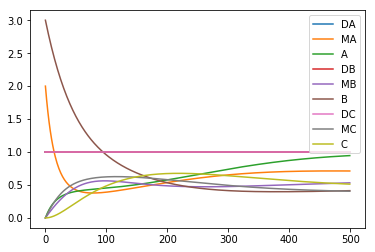

test


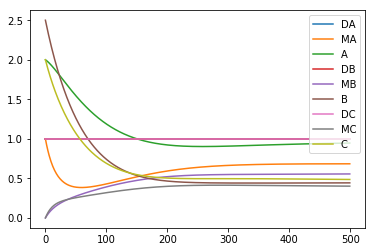

In [53]:
def plot_and_persist_lma_traj(t):
    plt.plot(t.counts[:, 0], label=species_names[0])
    plt.plot(t.counts[:, 1], label=species_names[1])
    plt.plot(t.counts[:, 2], label=species_names[2])
    plt.plot(t.counts[:, 3], label=species_names[3])
    plt.plot(t.counts[:, 4], label=species_names[4])
    plt.plot(t.counts[:, 5], label=species_names[5])
    plt.plot(t.counts[:, 6], label=species_names[6])
    plt.plot(t.counts[:, 7], label=species_names[7])
    plt.plot(t.counts[:, 8], label=species_names[8])
    plt.legend(loc="best")
    plt.show()
    t.persist()

print("train")
t = analysis.generate_or_load_traj_lma(train_n, target_time, noise_variance=noise_variance)
plot_and_persist_lma_traj(t)
print("test")
t = analysis.generate_or_load_traj_lma(test_n, target_time, noise_variance=noise_variance)
plot_and_persist_lma_traj(t)

In [54]:
for t in traj_n_s:
    traj = analysis.get_traj(t)
    for sp in [0, 3, 6]:
        dx = np.zeros_like(traj.counts[:, sp])
        print("species {} dx.shape {}".format(sp, dx.shape))
        traj.separate_derivs[sp] = dx
    for sp in [1, 2, 4, 5, 7, 8]:
        x = traj.counts[:, sp]
        dx = np.zeros_like(x)
        dt = traj.time_step
        dx = np.gradient(x) / dt
        print("species={} dx.shape={} dt={}".format(sp, dx.shape, dt))
        traj.separate_derivs[sp] = dx
    traj.persist()

species 0 dx.shape (500,)
species 3 dx.shape (500,)
species 6 dx.shape (500,)
species=1 dx.shape=(500,) dt=0.006
species=2 dx.shape=(500,) dt=0.006
species=4 dx.shape=(500,) dt=0.006
species=5 dx.shape=(500,) dt=0.006
species=7 dx.shape=(500,) dt=0.006
species=8 dx.shape=(500,) dt=0.006
species 0 dx.shape (500,)
species 3 dx.shape (500,)
species 6 dx.shape (500,)
species=1 dx.shape=(500,) dt=0.006
species=2 dx.shape=(500,) dt=0.006
species=4 dx.shape=(500,) dt=0.006
species=5 dx.shape=(500,) dt=0.006
species=7 dx.shape=(500,) dt=0.006
species=8 dx.shape=(500,) dt=0.006


In [55]:
if False:
    analysis.calculate_lma_fd_derivative(train_n, target_time)
    analysis.calculate_lma_fd_derivative(test_n, target_time)

In [56]:
# species DA  MA  A  DB  MB  B  DC  MC  C
# ids     0   1   2  3   4   5  6   7   8
if False:
    analysis.obtain_lma_trajectories(
        target_time,
        noise_variance=noise_variance,
        species=[1, 2, 4, 5, 7, 8],
        # alphas=np.linspace(0.0005, 0.01, num=8),
        alphas=np.array([0.001, 0.0011]),
        verbose=True, 
        atol=5e-5,
        maxit=50, 
        search_depth=1, 
        selection=[test_n],
        #subdivisions=3,
        override=False,
    )

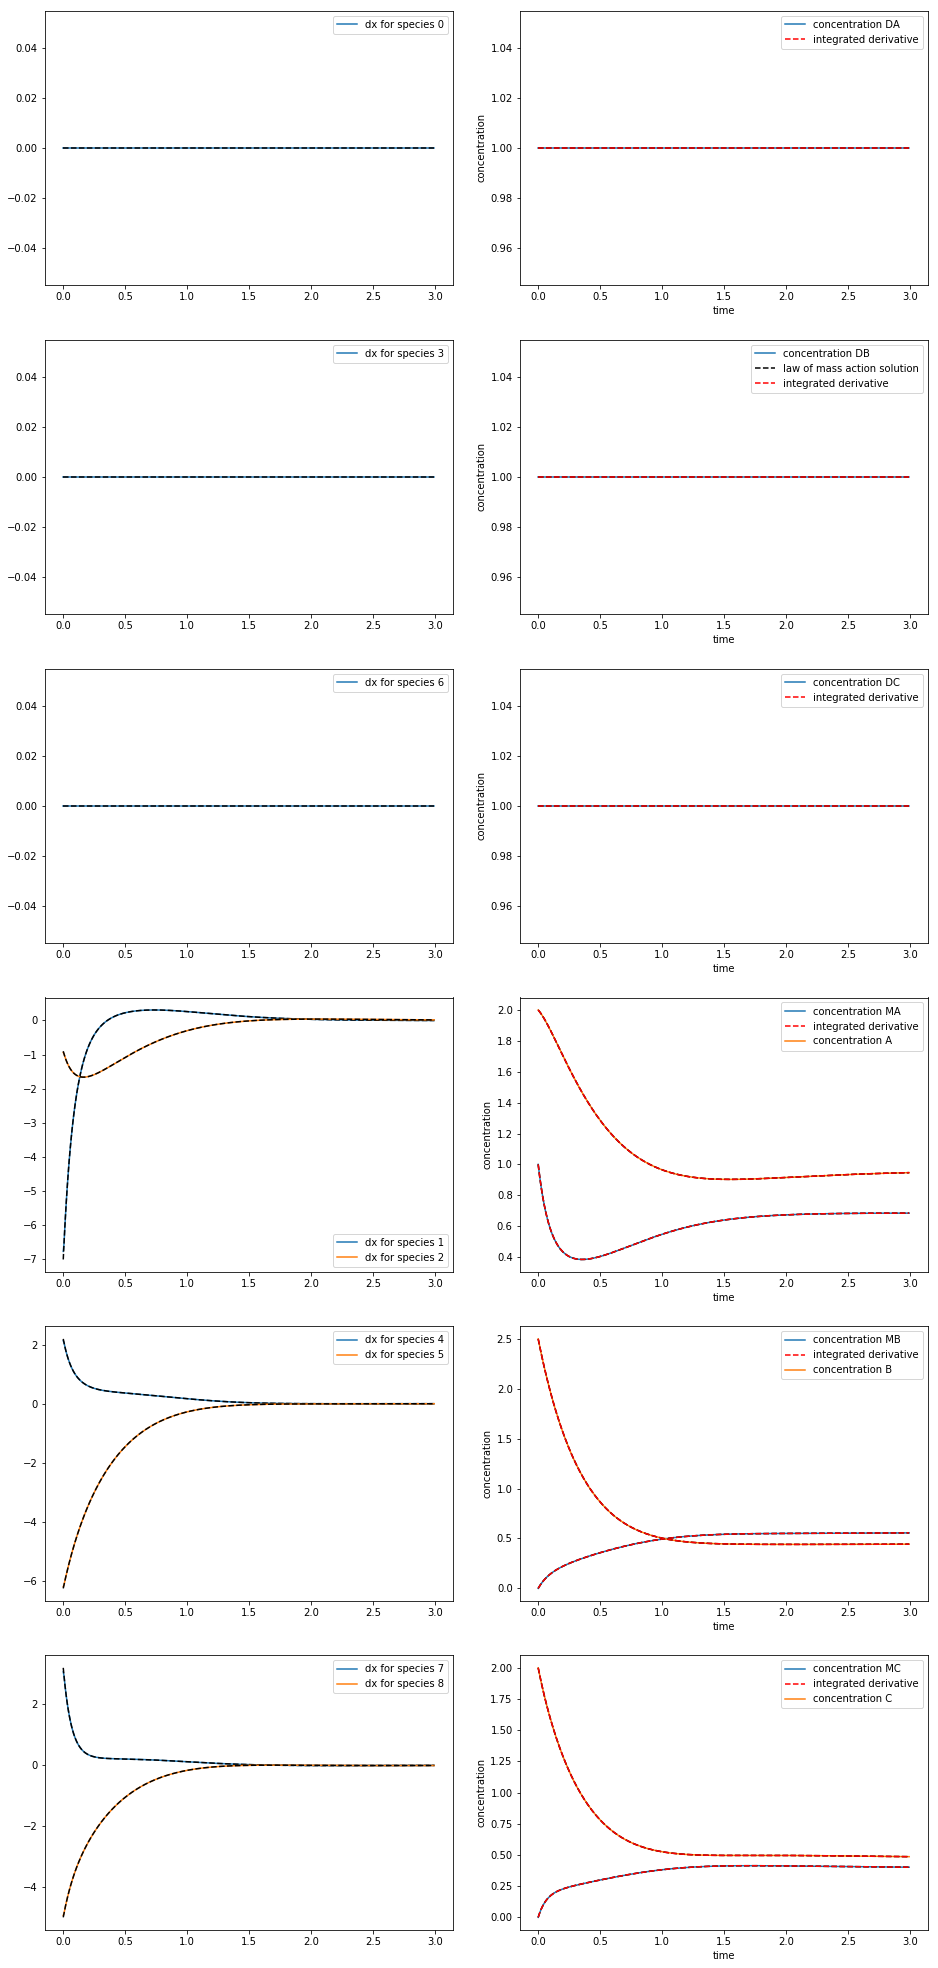

In [57]:
traj_number=test_n
pfs = [
    lambda t=traj_number: analysis.plot_derivatives(t, species=[0]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[0]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[3]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[3]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[6]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[6]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[1, 2]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[1, 2]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[4, 5]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[4, 5]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[7, 8]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[7, 8])
]
plot_overview(pfs, n_cols=2, n_rows=6, size_factor=1.3)
plt.show()

train_n 1 test_n 2


IntProgress(value=0, max=47)

params: alpha=7.6e-06, l1=1.0 with corresponding score 0.00395428851536712
train_n 1
optimization problem did exit successfully (alpha=7.6e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
352 / 30000 iterations


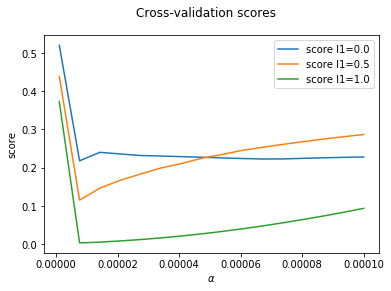

In [81]:
est_rates, cv_res = ana.do_the_cv(
    analysis,
    train_n=train_n,
    test_n=test_n,
    alphas=np.linspace(0.000001,0.0001,num=16),
    #alphas=np.array([0.000000001,0.0000000011]),
    l1_ratios=np.linspace(0., 1., num=3),
    recompute=True
)
ana.plot_cv_results(cv_res, mainscore=0, best_params_ix_l1=None)

In [82]:
l1_norm = sum([abs(r) for r in desired_rates])
print("L1 norm of desired rates = {}".format(l1_norm))
alpha = 7.6e-06
print("L1 norm * alpha = {}".format(alpha * l1_norm))

L1 norm of desired rates = 39.400000000000006
L1 norm * alpha = 0.00029944000000000005


Text(0.5,1,'L1 regularization')

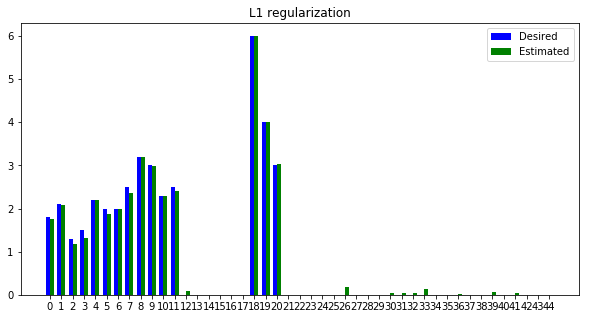

In [93]:
ana.plot_rates_bar(desired_rates, est_rates)
plt.title("L1 regularization")

In [75]:
lsq_rates = analysis.solve(train_n, 0., 1., recompute=True, tol=1e-16)

optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
377 / 30000 iterations


In [89]:
from importlib import reload

In [90]:
reload(ana)

<module 'readdy_learn.analyze.analyze' from '/home/mi/chrisfr/workspace/readdy_learn_pycharm/readdy_learn/analyze/analyze.py'>

Text(0.5,1,'Least-squares')

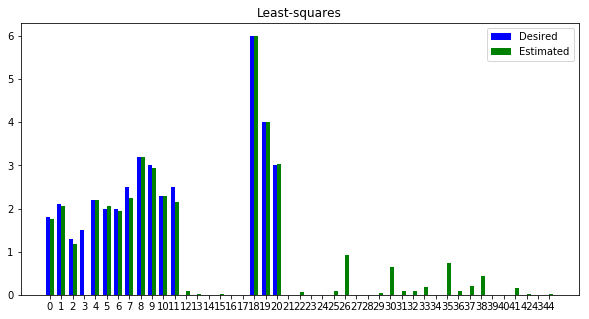

In [92]:
ana.plot_rates_bar(desired_rates, lsq_rates)
plt.title("Least-squares")

In [77]:
lsq_rates - est_rates

array([ 4.59286062e-04, -3.16437089e-02,  1.06833812e-03, -1.31976328e+00,
       -1.13027278e-03,  2.15054059e-01, -5.56011302e-02, -9.47706322e-02,
        1.23490722e-03, -3.30105649e-02,  1.73932761e-03, -2.57024631e-01,
       -2.60641228e-04,  1.09006532e-02, -6.33266973e-04,  2.94004935e-02,
        6.84346258e-18,  0.00000000e+00,  2.20458975e-03,  9.86296195e-03,
       -2.14531170e-04,  0.00000000e+00,  5.45259820e-02, -6.33266973e-04,
        0.00000000e+00,  9.33879419e-02,  7.52331038e-01,  4.83135600e-17,
        6.49644248e-17,  4.10997463e-02,  6.03270151e-01,  2.57322214e-02,
        5.29587162e-02,  3.04960108e-02,  0.00000000e+00,  7.28973353e-01,
        7.08453147e-02,  1.96456298e-01,  4.40914705e-01, -7.93219505e-02,
       -2.61101245e-04,  1.22665763e-01,  1.92656211e-02,  3.21229514e-18,
        1.72797127e-02])

In [78]:
np.sum(est_rates)

39.26859327422148

In [79]:
np.sum(lsq_rates)

40.91645148901568

In [80]:
np.sum(desired_rates)

39.400000000000006

## el problem w/ noise: least squares solution is already smaller than desired rates, L1 will only work in the converse case

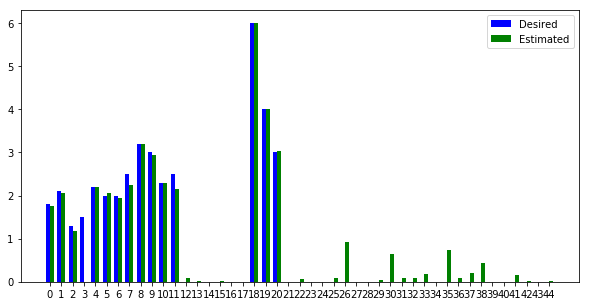

In [94]:
ana.plot_rates_bar(desired_rates, lsq_rates)

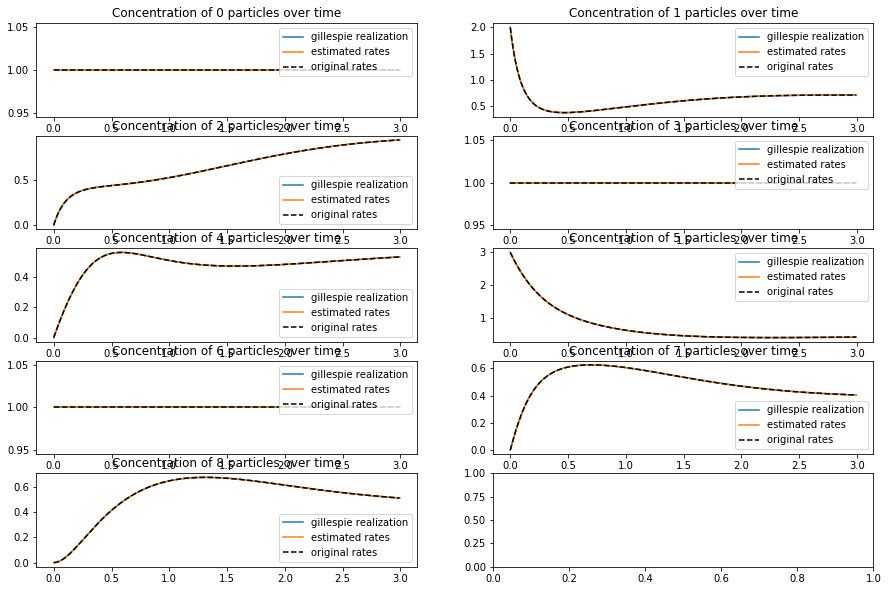

In [95]:
analysis.plot_results(train_n, est_rates)

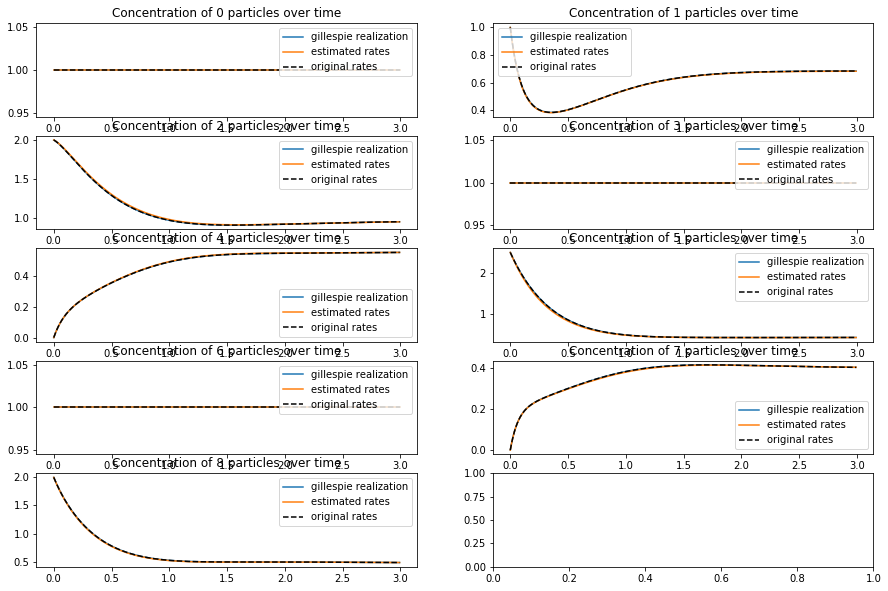

In [96]:
analysis.plot_results(test_n, est_rates)

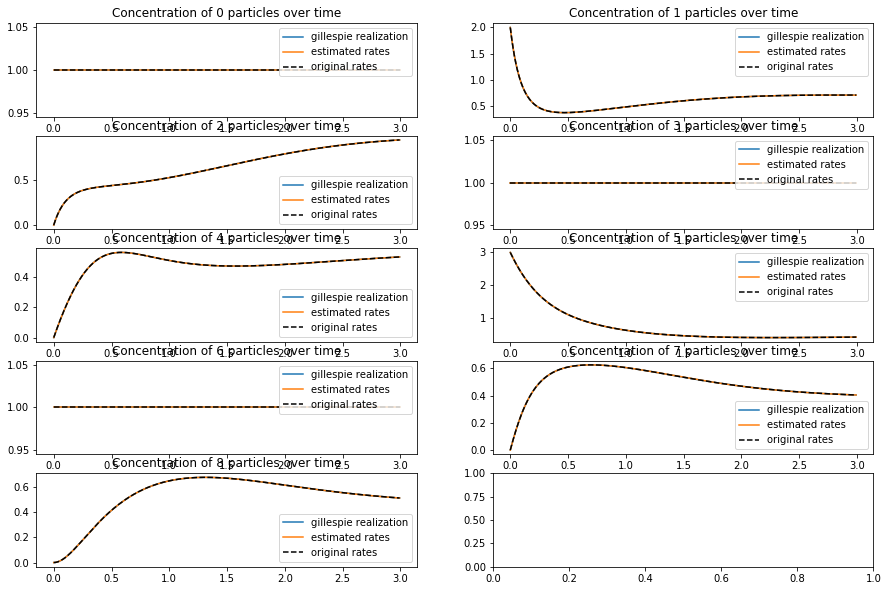

In [97]:
analysis.plot_results(train_n, lsq_rates)

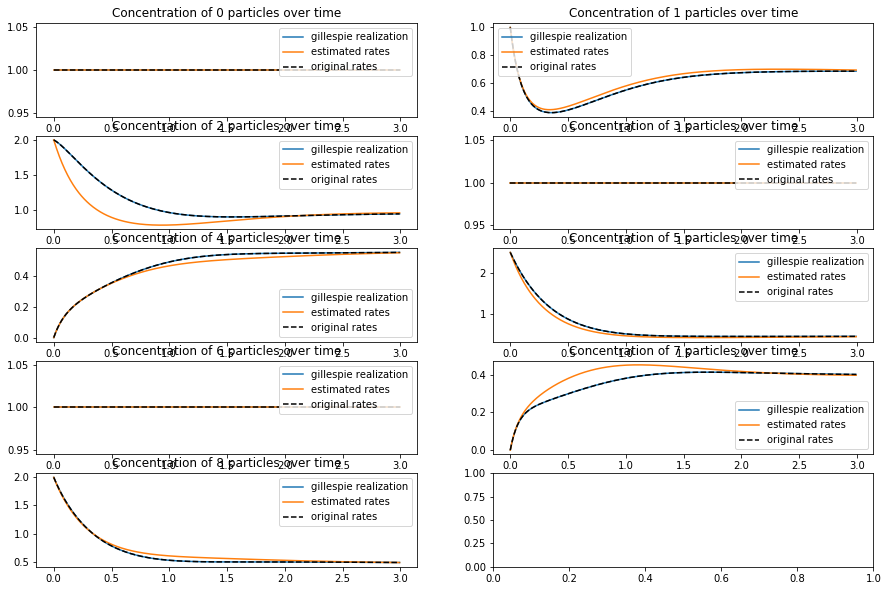

In [98]:
analysis.plot_results(test_n, lsq_rates)